In [1]:
import os
import re
import sys
import glob
import shutil
import numpy as np
import pandas as pd
from scipy import sparse, io
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scanpy.external as sce

In [2]:
matplotlib.rcParams.update({'font.size': 12})
# %config InlineBackend.figure_format = 'retina'
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html
# https://eleozzr.github.io/desc/tutorial.html

In [46]:
# cmd params
arg_keys = {
    'work_dir': "--work_dir=",
}
args = dict()
for argv in sys.argv[1:]:
    for k, arg_key in arg_keys.items():
        if argv.find(arg_key) == 0:
            args[k] = argv[len(arg_key):]

In [3]:
# ### /** Windows operation system **/
# work_dir = 'D:/Document/Programming/Python/deepbio/symphony/github/scanalysis/scqqapy/data/h5/sarcoma/'
# args = dict()
# args['work_dir'] = work_dir
# args['data_work_dir'] = work_dir
# args['fig_work_dir'] = work_dir

# ### /** Linux operation system **/
args['data_work_dir'] = args['work_dir'] + 'scanpy_integ_6_clustering.dir/'
args['fig_work_dir'] = args['work_dir'] + 'scanpy_integ_6_clustering_fig.dir/'

In [4]:
# read
adata = sc.read_h5ad(args['work_dir'] + 'scanpy_integ_5_be.dir/adata_be.h5ad')
print(adata.obs['sample'].value_counts())

119289-CCS-08-snRNAseq_S2    6717
119290-CCS-15-snRNAseq_S3    2029
119291-CCS-72-snRNAseq_S4    2021
119288-CCS-07-snRNAseq_S1    1251
Name: sample, dtype: int64


## Clustering

In [5]:
def console(adata):
    print('remaining cells: {}, remaining genes: {}'.format(adata.X.shape[0], adata.X.shape[1]))
    
def saveTo(old_fn='scatter', new_fn='stat_basic', kind='.pdf'):
    os.replace(os.path.join(os.getcwd(), 'figures/' + old_fn + kind), os.path.join(os.getcwd(), 'figures/' + new_fn + kind))
    shutil.move(os.path.join(os.getcwd(), 'figures/' + new_fn + kind), args['fig_work_dir'] + new_fn + kind)
    shutil.rmtree(os.path.join(os.getcwd(), 'figures'))

In [6]:
adata_cp = adata.copy()
adata_cp

AnnData object with n_obs × n_vars = 12018 × 34540
    obs: 'type', 'sample', 'batch', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'desc_0.8', 'max.prob0.8'
    var: 'gene_name', 'n_cells'
    uns: 'desc_0.8_colors', 'doublet_info_colors', 'prob_matrix0.8', 'sample_colors'
    obsm: 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8'

In [7]:
sc.pp.normalize_per_cell(adata_cp, counts_per_cell_after=1e4)
sc.pp.log1p(adata_cp)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [8]:
sc.pp.highly_variable_genes(adata_cp, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
sc.pp.scale(adata_cp, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [10]:
# %%time
sc.tl.pca(adata_cp, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata_cp, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata_cp)

computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 10


D:\Programming\anaconda3\envs\scanal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)
CPU times: total: 25.3 s
Wall time: 21 s


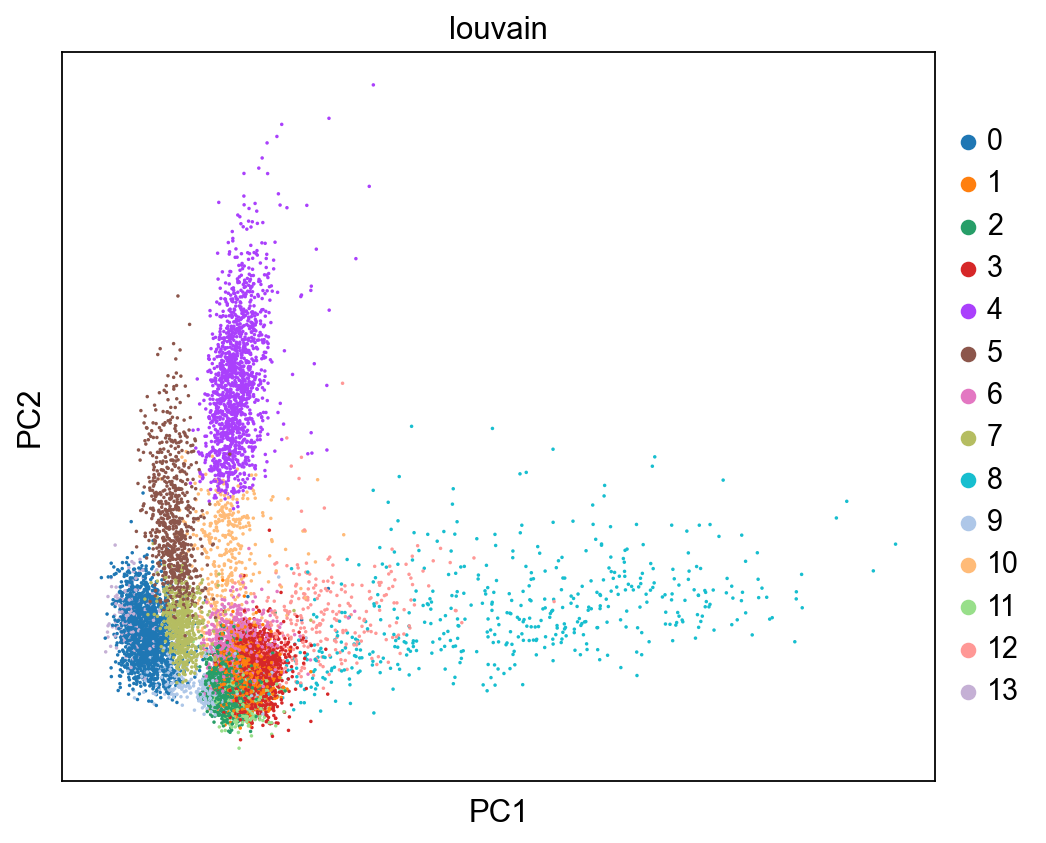

In [12]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.pca(adata_cp, color='louvain', ax=ax)
fig.savefig(args['fig_work_dir'] + 'pca.pdf', bbox_inches="tight", dpi=300)

In [13]:
# %%time
sc.tl.tsne(adata_cp, n_pcs=10)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE


D:\Programming\anaconda3\envs\scanal\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:47)
CPU times: total: 8min 33s
Wall time: 47.2 s


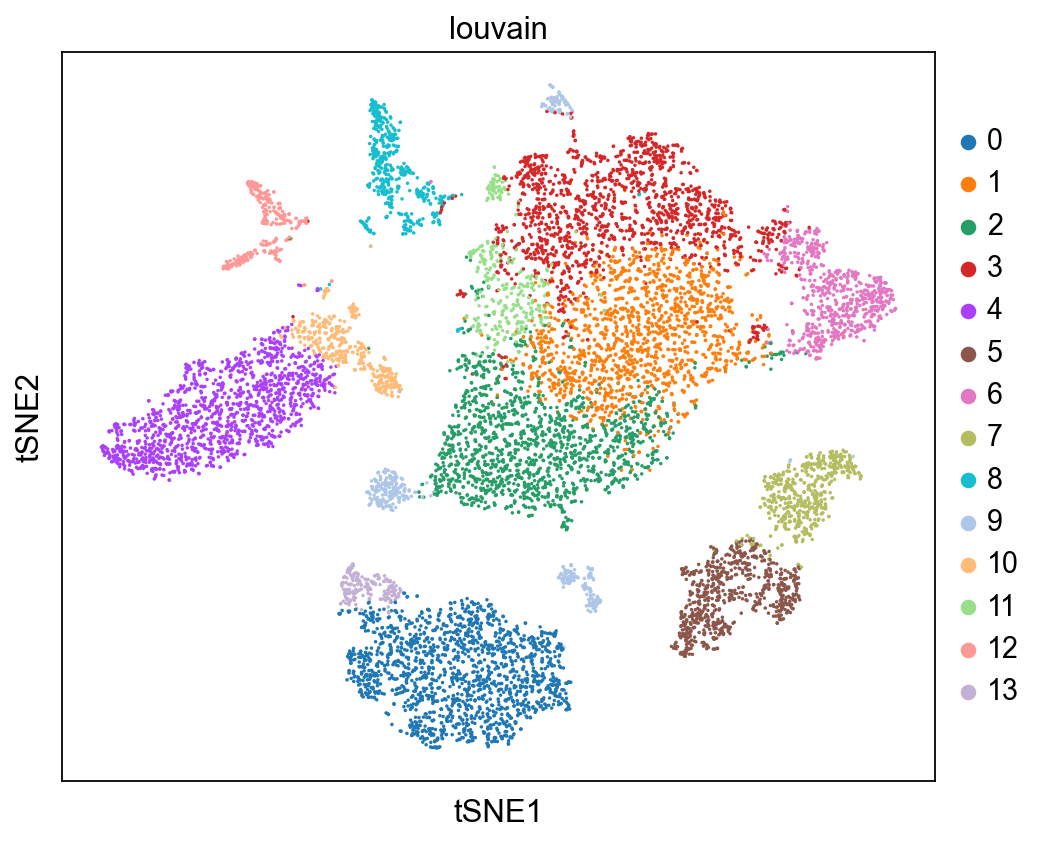

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.tsne(adata_cp, color='louvain', ax=ax)
fig.savefig(args['fig_work_dir'] + 'tsne.pdf', bbox_inches="tight", dpi=300)

In [15]:
# %%time
sc.tl.umap(adata_cp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
CPU times: total: 9.56 s
Wall time: 9.27 s


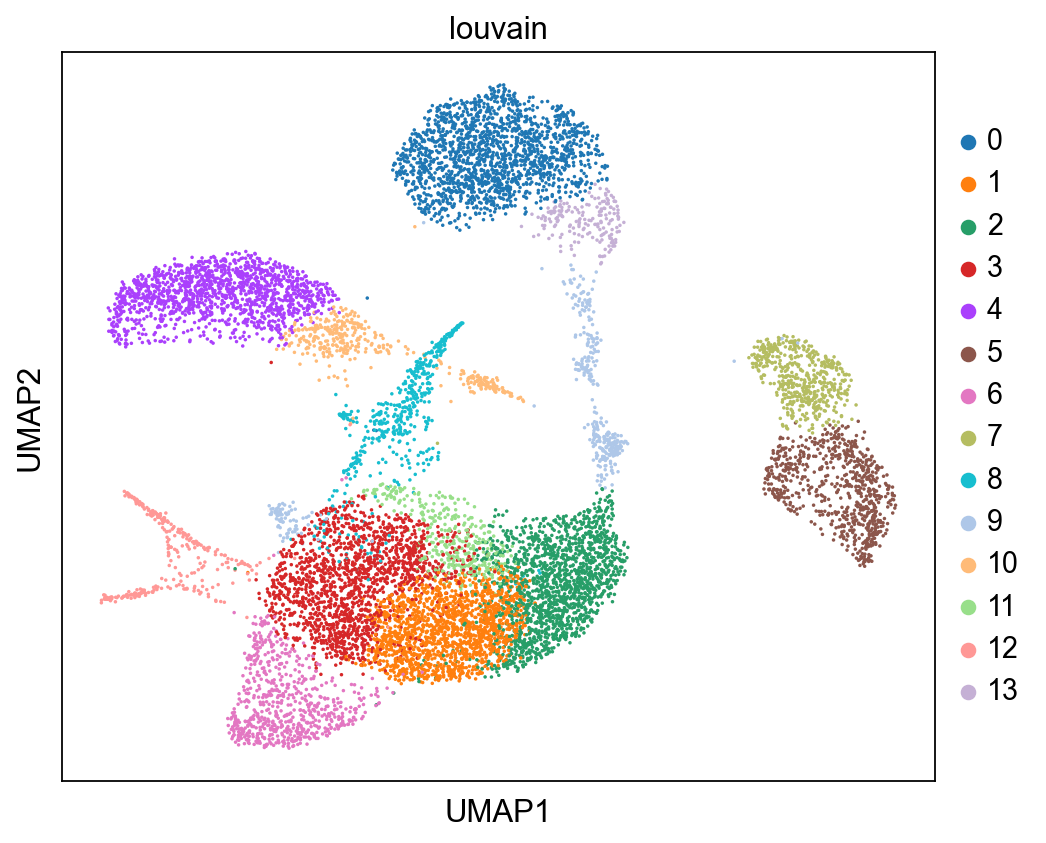

In [17]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(adata_cp, color='louvain', ax=ax)
fig.savefig(args['fig_work_dir'] + 'umap.pdf', bbox_inches="tight", dpi=300)

In [18]:
sc.external.pp.bbknn(adata_cp, batch_key='batch')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


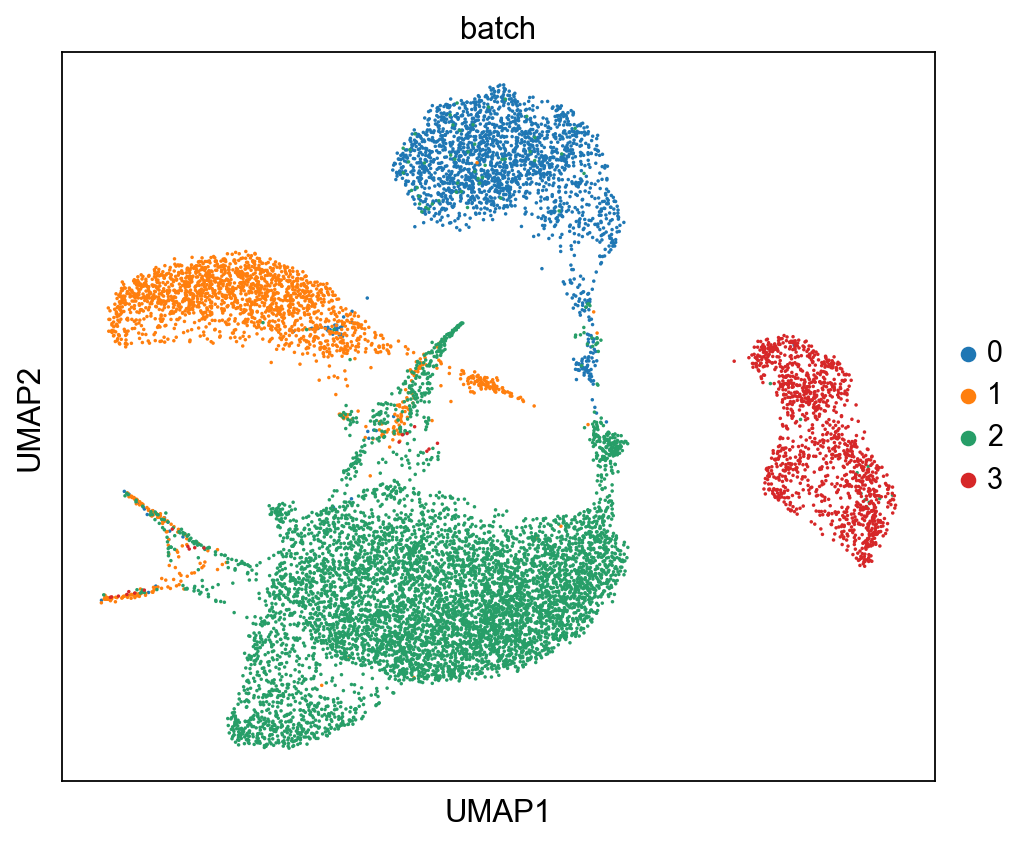

In [21]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(adata_cp, color='batch', ax=ax)
fig.savefig(args['fig_work_dir'] + 'umap_batch.pdf', bbox_inches="tight", dpi=300)

In [22]:
adata_cp

AnnData object with n_obs × n_vars = 12018 × 34540
    obs: 'type', 'sample', 'batch', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'desc_0.8', 'max.prob0.8', 'louvain'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'desc_0.8_colors', 'doublet_info_colors', 'prob_matrix0.8', 'sample_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'tsne', 'umap', 'batch_colors'
    obsm: 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
adata

AnnData object with n_obs × n_vars = 12018 × 34540
    obs: 'type', 'sample', 'batch', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'desc_0.8', 'max.prob0.8'
    var: 'gene_name', 'n_cells'
    uns: 'desc_0.8_colors', 'doublet_info_colors', 'prob_matrix0.8', 'sample_colors'
    obsm: 'X_Embeded_z0.8', 'X_tsne0.8', 'X_umap0.8'

In [25]:
sce.pp.harmony_integrate(adata_cp, key='batch', basis='X_pca')
# sc.tl.tsne(adata_harmony_cp, use_rep='X_pca_harmony')
# sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True, use_rep='X_pca_harmony')
# sc.tl.umap(adata)

2022-05-15 21:22:21,779 - harmonypy - INFO - Iteration 1 of 10
2022-05-15 21:22:24,191 - harmonypy - INFO - Iteration 2 of 10
2022-05-15 21:22:26,706 - harmonypy - INFO - Converged after 2 iterations


In [26]:
adata.obs['louvain'] = adata_cp.obs['louvain']
adata.uns['louvain'], adata.uns['louvain_colors'], adata.uns['pca'], adata.uns['neighbors'], adata.uns['tsne'], adata.uns['umap'], adata.uns['batch_colors'] = adata_cp.uns['louvain'], adata_cp.uns['louvain_colors'], adata_cp.uns['pca'], adata_cp.uns['neighbors'], adata_cp.uns['tsne'], adata_cp.uns['umap'], adata_cp.uns['batch_colors']
adata.obsm['X_pca'], adata.obsm['X_tsne'], adata.obsm['X_umap'], adata.obsm['X_pca_harmony'] = adata_cp.obsm['X_pca'], adata_cp.obsm['X_tsne'], adata_cp.obsm['X_umap'], adata_cp.obsm['X_pca_harmony']

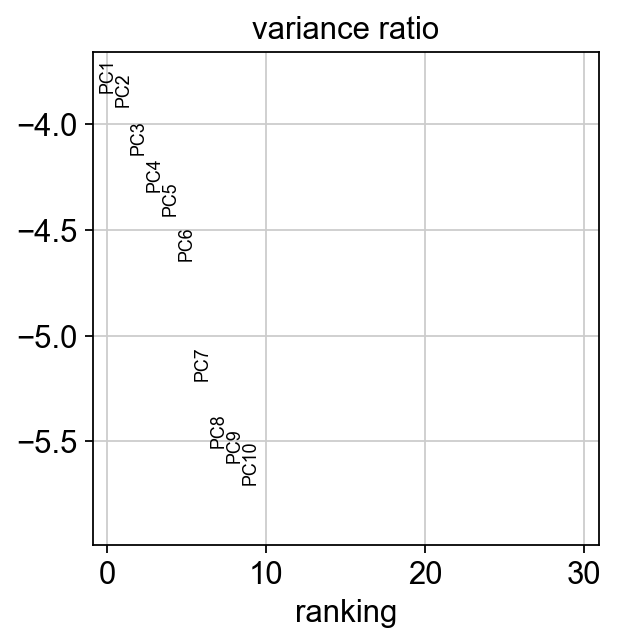

In [30]:
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')
saveTo(old_fn='pca_variance_ratio', new_fn='pca_scree', kind='.pdf')

In [31]:
del(adata_cp)

In [32]:
adata.write(args['data_work_dir'] + 'adata_clustering.h5ad')